In [ ]:
import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

path3 = kagglehub.dataset_download("isuranga/load-forecasting-dataset")

df = pd.read_csv(os.path.join(path3, 'load_forecasting_dataset_corrected.csv'))
df = df.rename(columns={'Timestamp': 'timestamp', 'Load Demand (kW)': 'load', 'Temperature (°C)': 'temp', 'Electricity Price (LKR/kWh)': 'price', 'GDP (LKR)': 'gdp'})
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna().sort_values('timestamp').reset_index(drop=True)

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# We include the extra long-term features here
final_data = df[['load', 'temp', 'price', 'gdp', 'hour', 'day_of_week']].values

100%|██████████| 10.5M/10.5M [00:00<00:00, 199MB/s]

Extracting files...


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_data)

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window, :])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_data, window_size)

# Total hours ~43,800. 3 years (365*24*3) is 26,280 hours.
train_size = 26280
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


740/740 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0280 - val_loss: 0.0115
Epoch 2/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.0146 - val_loss: 0.0117
Epoch 3/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0135 - val_loss: 0.0114
Epoch 4/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - loss: 0.0130 - val_loss: 0.0114
Epoch 5/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 6/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 7/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 8/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 9/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 10/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 11/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 12/30
740/740 ━━━━━━━━━━━━━━━━━━━━ 

5112/5112 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step
Seasonal LSTM MAE: 159.59281304932207 kW
Seasonal LSTM RMSE: 199.98835822774822 kW


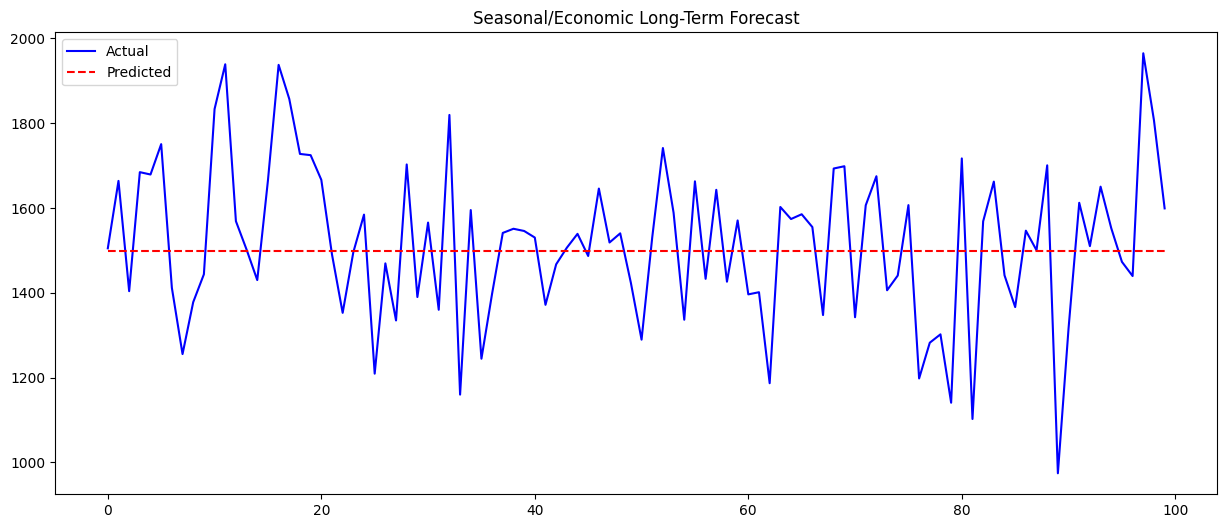

In [ ]:
predictions = model.predict(X_test)

pred_dummy = np.zeros((len(predictions), final_data.shape[1]))
pred_dummy[:, 0] = predictions.flatten()
predictions_unscaled = scaler.inverse_transform(pred_dummy)[:, 0]

actual_dummy = np.zeros((len(y_test), final_data.shape[1]))
actual_dummy[:, 0] = y_test
actual_unscaled = scaler.inverse_transform(actual_dummy)[:, 0]

mae = mean_absolute_error(actual_unscaled, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(actual_unscaled, predictions_unscaled))

print(f"Seasonal LSTM MAE: {mae} kW")
print(f"Seasonal LSTM RMSE: {rmse} kW")

plt.figure(figsize=(15, 6))
plt.plot(actual_unscaled[:100], label='Actual', color='blue')
plt.plot(predictions_unscaled[:100], label='Predicted', color='red', linestyle='--')
plt.title('Seasonal/Economic Long-Term Forecast')
plt.legend()
plt.show()

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lr = LinearRegression().fit(X_train_flat, y_train)
rf = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_train_flat, y_train)
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train_flat, y_train)
dt = DecisionTreeRegressor(random_state=42).fit(X_train_flat, y_train)

def get_mae(pred):
    dummy = np.zeros((len(pred), final_data.shape[1]))
    dummy[:, 0] = pred
    return mean_absolute_error(actual_unscaled, scaler.inverse_transform(dummy)[:, 0])

models = ['Linear Regression', 'Random Forest', 'KNN', 'Decision Tree', 'LSTM']
results = [get_mae(lr.predict(X_test_flat)), get_mae(rf.predict(X_test_flat)),
           get_mae(knn.predict(X_test_flat)), get_mae(dt.predict(X_test_flat)), mae]

performance_df = pd.DataFrame({'Model': models, 'MAE': results})
print(performance_df)

performance_df.plot(kind='bar', x='Model', y='MAE', color='skyblue')
plt.show()

NameError: name 'X_train' is not defined